# HW Tool

## 1. `shap.plots.beeswarm` нормального человека (6 баллов)

Как вы могли видеть, у встроенного beeswarm plot`а есть несколько недостатков:
- нет информации о том, какие именно значения категориальных признаков в какую сторону толкают предсказания модели
- иногда серые точки (пропущенные значения) прячутся за точками другого цвета -> их не видно (см. rooms_num на графике с семинара)
- иногда раскраска бывает некорректной (потому что она раскрашивает по абсолютным значениям)

Вам предлагается реализовать свою версию shap.plots.beeswarm, которая исправляет эти недостатки.


Итак, требуется написать функцию, которая принимает на вход shap_values и все необходимое и строит по этим данным beeswarm plot
    без вышеперечисленных недостатков, а именно:
- теперь все уникальные значения кат. фич становятся как бы отдельными фичами, по ним видны shap_values (см. пример)
    - чтобы не захламлять ваш график редковстречающимися категориями, принимайте на вход параметр, чтобы контролировать это
    - такие фичи должны быть покрашены в особый цвет, чтобы отличаться от числовых
- точки, отвечающие за наны, должны быть хорошо видны на фоне остальных и не перекрывать их
- раскраска должна адекватно красить ваши точки
    - можно выкидывать выбросы перед покраской
    - можно логарифмировать значения
    - можно красить по квантилям, а не по абсолютным значениям
    - лучше всего красятся равномерное и нормальное распределение

**Обязательно:**
- docstring
- комменты к непонятным кускам кода - что там происходит
- принимайте на вход кол-во фич, которые вы отображаете на графике
- принимайте на вход размер фигуры
- нарисуйте вертикальную линию, обозначающую 0
- сортируйте признаки по среднему модулю shap_values
- используйте stripplot (или аналоги) с jitter`ом, а не swarmplot
- принимайте на вход кол-во точек которое будете отрисовывать (500-3000 = норм)
    - если для какого-то значения кат фичи точек меньше, чем вы задали, рисуйте сколько есть

**!**
Если на вход подана слишком большая выборка, вы можете под капотом сэмплить из нее какое-то адекватное кол-во точек и отрисовывать их.
Однако, раскраску и контроль за отрисовкой категорий лучше базировать на всей выборке, поданной на вход.


Ниже приведен пример. Не меняйте код, предшествующий примеру. Вы не обязаны повторять пример точь-в-точь, это ориентир. Не удаляйте пример.

Удачи!

In [ ]:
import numpy as np, pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter('ignore', PerformanceWarning)


df = pd.read_parquet('train_sber.parquet')
features = df.columns.drop(['timestamp', 'result_price', 'result_price_bin'])

model = lgb.Booster(model_file='model.lgb')
shap_values = model.predict(df[features], pred_contrib=True)

'''
Учтите, что если вы считаете shap_values через LightGBM,
    shap_values - np.array of shape (N, F + 1), где последний столбец - константа = среднее предсказание для всех объектов
'''
print('features shape:', features.shape, 'shap_values shape:', shap_values.shape)
df.head(3)

[LightGBM] [Warning] Ignoring unrecognized parameter 'bagging_by_query' found in model string.
features shape: (36,) shap_values shape: (27232, 37)


,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance,result_price_bin
0,6407578.100,1.422391,3.830951,NaN,13.675657,24.292406,152,0.485841,4.0,86206,...,3.299822,13.100618,0.177975,52,NaN,Bibirevo,2011-08-20,52,14.231961,False
1,9589336.912,2.887377,3.103996,NaN,8.132640,5.706113,177,0.668364,3.0,76284,...,0.783160,6.444333,0.273345,66,NaN,Nagatinskij Zaton,2011-08-23,40,9.242586,False
2,4808269.831,0.647250,2.927487,NaN,8.054252,6.710302,122,0.733101,2.0,101982,...,3.945073,6.963403,0.158072,67,NaN,Tekstil'shhiki,2011-08-27,35,9.540544,False


In [ ]:
def my_beeswarm(df: pd.DataFrame, features: list[str],
                cat_feature_threshold: float, shap_values: np.ndarray,
                top_k: int = 10, figsize: tuple[int, int] = (10, 6),
                dots: int = 1000) -> plt.Figure:
    """
    Улучшенная версия beeswarm plot для визуализации SHAP значений.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходные данные
    features : list[str]
        Список признаков
    cat_feature_threshold : float
        Порог для отображения категориальных значений (минимальная частота)
    shap_values : np.ndarray
        SHAP значения (N x F+1), последний столбец - константа
    top_k : int, optional
        Количество топовых признаков для отображения (по умолчанию 10)
    figsize : tuple[int, int], optional
        Размер фигуры (по умолчанию (10, 6))
    dots : int, optional
        Количество точек для отображения (по умолчанию 1000)

    Возвращает:
    -----------
    plt.Figure
        Объект matplotlib Figure с визуализацией
    """

    # 1. Предобработка SHAP значений
    shap_values = shap_values[:, :-1]
    df_shap = pd.DataFrame(shap_values, columns=features)

    # 2. Обработка категориальных признаков
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for cat in cat_cols:
        if cat not in features:
            continue

        value_counts = df[cat].value_counts(normalize=True)
        filtered_values = value_counts[value_counts >= cat_feature_threshold].index

        new_cols = {
            f"{cat} == {value}": (df[cat] == value).astype(int)
            for value in filtered_values
        }

        # Создаем новер бинарные признаки
        new_df = pd.DataFrame(new_cols)
        df = pd.concat([df, new_df], axis=1)

        # Для SHAP значений - копируем оригинальные значения только для соответствующих категорий
        for value in filtered_values:
            mask = (df[cat] == value)
            df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)

        df.drop(columns=[cat], inplace=True)
        df_shap.drop(columns=[cat], inplace=True)

    # 3. Выбор top_k признаков
    mean_shap_value = df_shap.abs().mean().sort_values(ascending=False)
    top_features = mean_shap_value.head(top_k).index.tolist()

    # 4. Сэмплирование
    if len(df) > dots:
        index_sample = np.random.choice(df.index, size=dots, replace=False)
        df_sampled = df.loc[index_sample]
        df_shap_sampled = df_shap.loc[index_sample]
    else:
        df_sampled = df.copy()
        df_shap_sampled = df_shap.copy()

    fig, ax = plt.subplots(figsize=figsize)

    # 5. Построение графика для каждого признака
    for i, feature in enumerate(top_features):
        # Подготовка данных для текущего признака
        shap_data = df_shap_sampled[feature]
        feature_data = df_sampled[feature] if feature in df_sampled else None

        # Разделение на пропущенные и непропущенные значения
        if feature_data is not None:
            is_missing = feature_data.isna()
            missing_shap = shap_data[is_missing]
            non_missing_shap = shap_data[~is_missing]
            non_missing_values = feature_data[~is_missing]
        else:
            # Для dummy-переменных нет пропущенных значений
            is_missing = pd.Series(False, index=shap_data.index)
            non_missing_shap = shap_data
            non_missing_values = None

        # Визуализация непропущенных значений
        if len(non_missing_shap) > 0:
            if " == " in feature:  # Категориальный признак
                sns.stripplot(
                    x=non_missing_shap.values,
                    y=[feature] * len(non_missing_shap),
                    ax=ax,
                    color='purple',
                    alpha=0.7,
                    jitter=0.3,
                    size=4,
                    linewidth=0.5
                )
            else:  # Числовой признак
                # Подготовка данных для цветового градиента
                vals = non_missing_values
                if vals.nunique() > 1:
                    # Обрезка выбросов для цветовой шкалы
                    vmin, vmax = vals.quantile([0.01, 0.99])
                    clipped_vals = vals.clip(vmin, vmax)

                    # Создаем DataFrame для stripplot, но можно было и просто записать все в параметры напрямую
                    plot_df = pd.DataFrame({
                        'shap': non_missing_shap.values,
                        'feature': [feature] * len(non_missing_shap),
                        'value': clipped_vals
                    })

                    # Рисуем с цветовым градиентом
                    sns.stripplot(
                        x='shap',
                        y='feature',
                        hue='value',
                        data=plot_df,
                        ax=ax,
                        palette='coolwarm',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5,
                        hue_norm=(vmin, vmax)
                    )

                    # Убираем легенду, потому что она будет дублировать colorbar
                    ax.get_legend().remove()
                else:
                    # Если все значения одинаковые - синий цвет
                    sns.stripplot(
                        x=non_missing_shap.values,
                        y=[feature] * len(non_missing_shap),
                        ax=ax,
                        color='blue',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5
                    )

        # Визуализация пропущенных значений
        if len(missing_shap) > 0:
            ax.plot(
                missing_shap.values,
                [feature]*len(missing_shap),
                'o',
                color='black',
                alpha=0.9,
                markersize=4,
                markeredgecolor='black',
                markeredgewidth=1,
                zorder = 10
            )

    # Добавление вертикальной линии на 0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    ax.set_xlabel('SHAP value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Custom Beeswarm Plot of SHAP Values', fontsize=14)

    # Добавление colorbar для числовых признаков
    if any(" == " not in f for f in top_features):
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Feature value (normalized)', rotation=270, labelpad=15)

    plt.tight_layout()

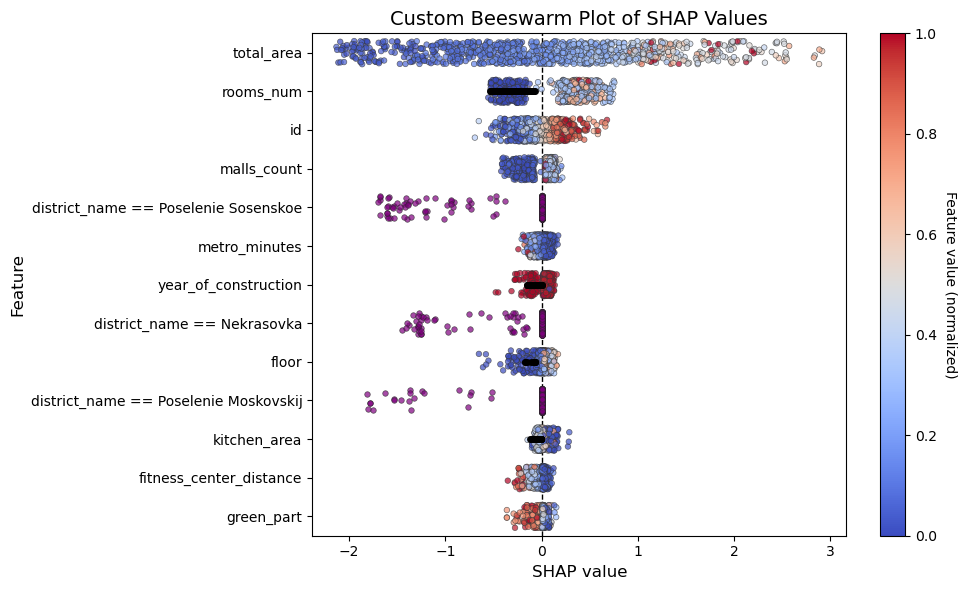

In [ ]:
my_beeswarm(df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

Пример ниже. Не удаляйте пример!

CPU times: total: 1.61 s
Wall time: 1.61 s


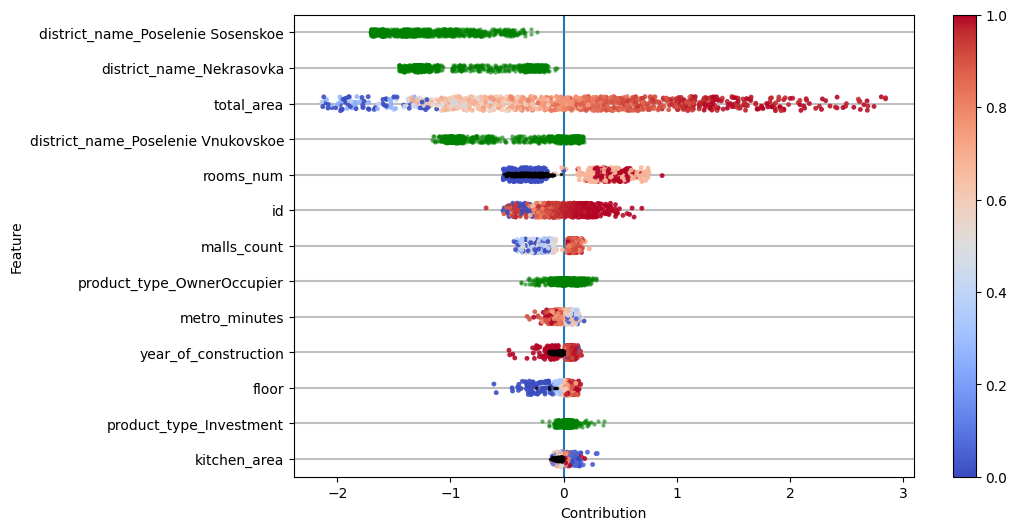

In [ ]:
%%time
from utils import shap_beeswarm

shap_beeswarm(model, df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

## 2. Логирование градиентов при обучении (4 балла)

**Задача:** хотим для каждого объекта для каждого дерева получить gi - производную лосса!
Чтобы:
- нарисовать карту объект-дерево
- поизучать 2D-представления
- призадуматься...

**Как:** придумайте способ! Нужно в процессе обучения сохранять градиенты LogLoss`а объектов на каждом дереве, после чего продемонстрировать собранные градиенты с помощью sns.clustermap.

Ниже пример. Не удаляйте пример!

-----------------------

Если продифференцировать логлосс и упростить, то получаем, что его градиент равен разности предсказаного значения и истинного

In [ ]:
def somehow_get_grads(model, tr, features=None):
    num_trees = model.num_trees()
    n_samples = len(tr)
    y_true = tr.result_price_bin.values

    if features is None:
        features = tr.columns.drop(['timestamp', 'result_price', 'result_price_bin']).tolist()

    # Явное преобразование категориальных признаков
    X = tr[features].copy()
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = X[col].astype('category').cat.codes

    grads = np.zeros((num_trees, n_samples))

    all_preds = np.array([
        model.predict(X.values, num_iteration=i+1, raw_score=True)
        for i in range(num_trees)
    ])

    y_pred_probs = 1.0 / (1.0 + np.exp(-all_preds))
    grads = y_pred_probs - y_true

    return grads

In [ ]:
def get_split(df, val_size=0.33, seed=None):
    if seed is not None:
        np.random.seed(seed)

    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.33, seed=32)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads(model, tr)
grads.shape

(300, 18245)

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


CPU times: total: 24.5 s
Wall time: 24.8 s


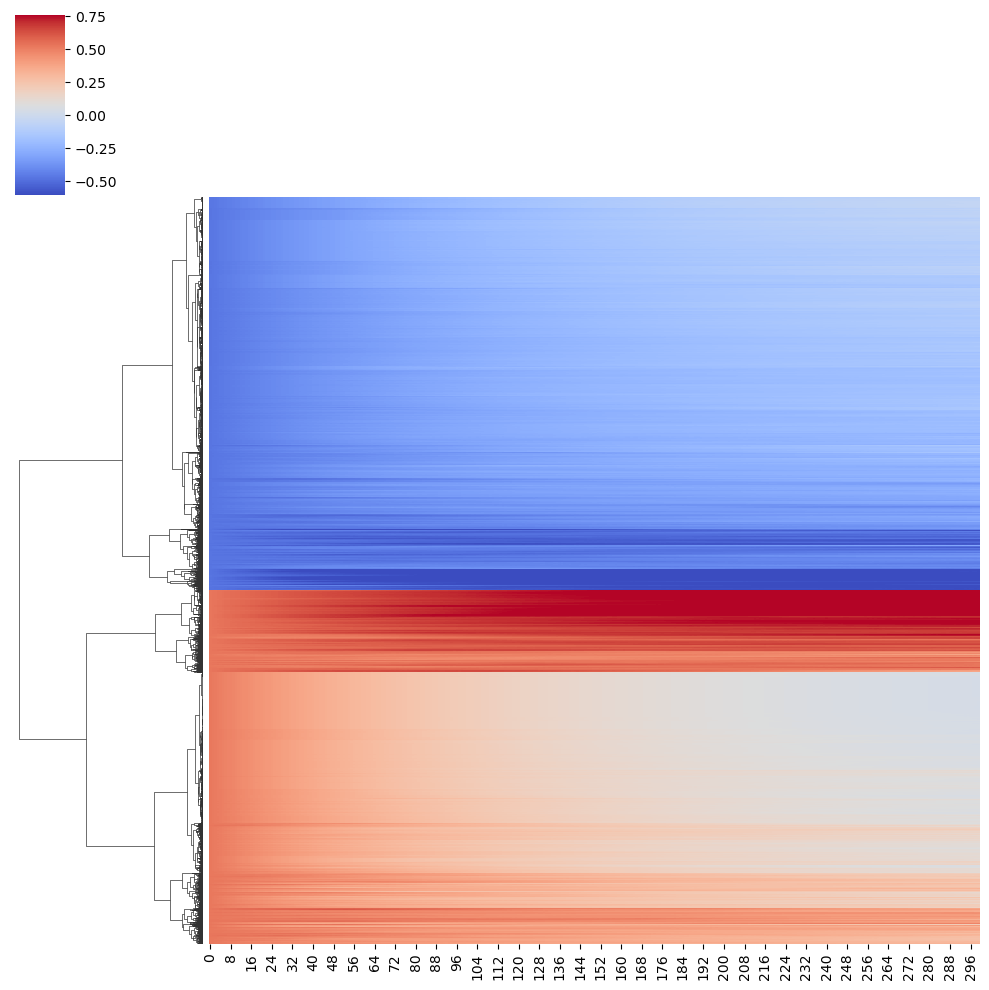

In [ ]:
%%time
import seaborn as sns

sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

Пример. Не удаляйте пример!

In [ ]:
def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads()
grads.shape

(100, 20968)

CPU times: total: 1min 17s
Wall time: 1min 17s


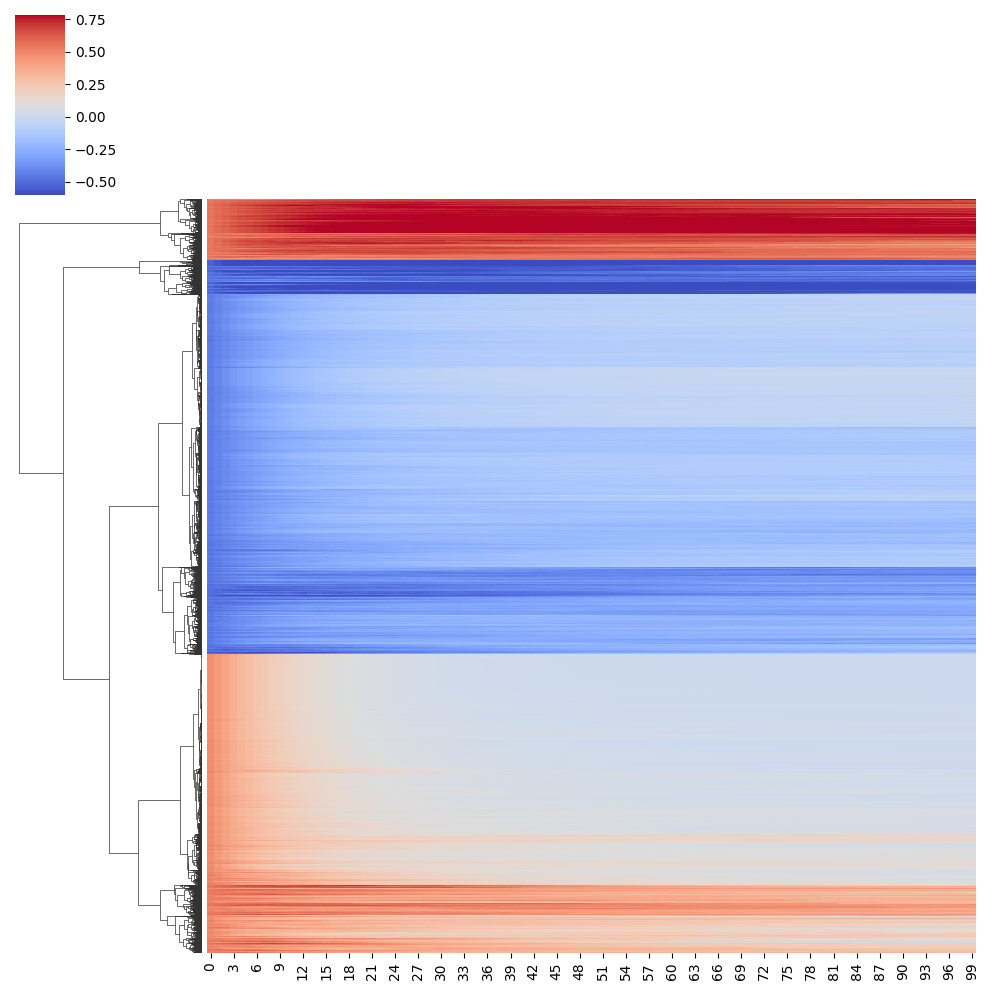

In [ ]:
%%time
import seaborn as sns

# предварительно установите fastcluster: pip install fastcluster, иначе считаться будет долго
sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

## 3. Автоматическое создание весов для бинарной классификации (5 баллов)

В этом блоке ваша цель - написать функцию, которая генерирует вектор весов для объектов обучающей выборки следующим образом:
1) на вход подается таргет-колонка и произвольная колонка
2) если колонка числовая, бьем ее на бины (кол-во бинов `bins` принимаем на вход. берем небольшое, около 7-13)
    - если в колонке < `bins` уникальных, бить не надо
3) если колонка категориальная, тоже бьем ее на бины
    - если уникальных значений <= `bins`, то за бины считаем уникальные значения категории
    - если уникальных значений >  `bins`, то выбираем `bins` - 1 самых популярных категорий у объектов класса 1
    - не попавшие в топ самых популярных категории запихиваем в бин 'other'

4) проходимся по всем бинам, присваивая всем объектам класса 1, попавшим в бин, вес n_0_in_bin / n_1_in_bin,
       если объектов класса 0, попавших в этот бин, достаточное кол-во (принимайте на вход, зависит от задачи)

5) всем объектам класса 0 присваиваем вес, равный единице

Такая схема на практике работает лучше, чем обычный `scale_pos_weight` параметр в LightGBM и его аналоги, если разумно выбирать
    вспомогательную колонку. Подумайте, как именно нужно выбирать такую колонку. Ответ писать не обязательно, но можно :)

**Обязательно:**
Найдите способ продемонстрировать визуализацией, что ваша функция работает корректно!

In [ ]:
def make_weights(target, feature, bins=10, min_n0=10):
    weights = np.ones(len(target), dtype=float)

    is_numeric = pd.api.types.is_numeric_dtype(feature)
    unique_values = feature.nunique()

    if is_numeric:
        if unique_values < bins:
            binned = feature
        else:
            binned = pd.cut(feature, bins = bins, duplicates='drop')
    else:
        if unique_values <= bins:
            binned = feature
        else:
            top_cat = feature[target == 1].value_counts().head(bins - 1).index
            binned = feature.where(feature.isin(top_cat), other='other')

    for bin_label in binned.unique():
        mask = (binned == bin_label)
        n0 = ((target == 0) & mask).sum()
        n1 = ((target == 1) & mask).sum()

        if n0 >= min_n0 and n1 > 0:
            weight_value = n0 / n1
            weights[(target == 1) & mask] = weight_value

    return weights, binned

def visual(binned, target, weights):
    df = pd.DataFrame({
        'bin': binned,
        'target': target,
        'weight': weights
    })

    grouped = df.groupby('bin').apply(
        lambda x: pd.Series({
            'n0': (x['target'] == 0).sum(),
            'n1': (x['target'] == 1).sum(),
            'avg_weight': x.loc[x['target'] == 1, 'weight'].mean() if (x['target'] == 1).sum() > 0 else 1.0
        })
    ).reset_index()

    grouped = grouped[grouped['n1'] > 0]

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    melted = pd.melt(grouped, id_vars=['bin'], value_vars=['n0', 'n1'])
    sns.barplot(x='bin', y='value', hue='variable', data=melted, ax=axes[0])
    axes[0].set_title('Number of Class 0 and 1 in Each Bin')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(x='bin', y='avg_weight', data=grouped, ax=axes[1])
    axes[1].axhline(1.0, color='r', linestyle='--', label='Default Weight (1.0)')
    axes[1].set_title('Average Weight for Class 1 in Each Bin')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_5808\1012088754.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5808\1012088754.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('bin').apply(


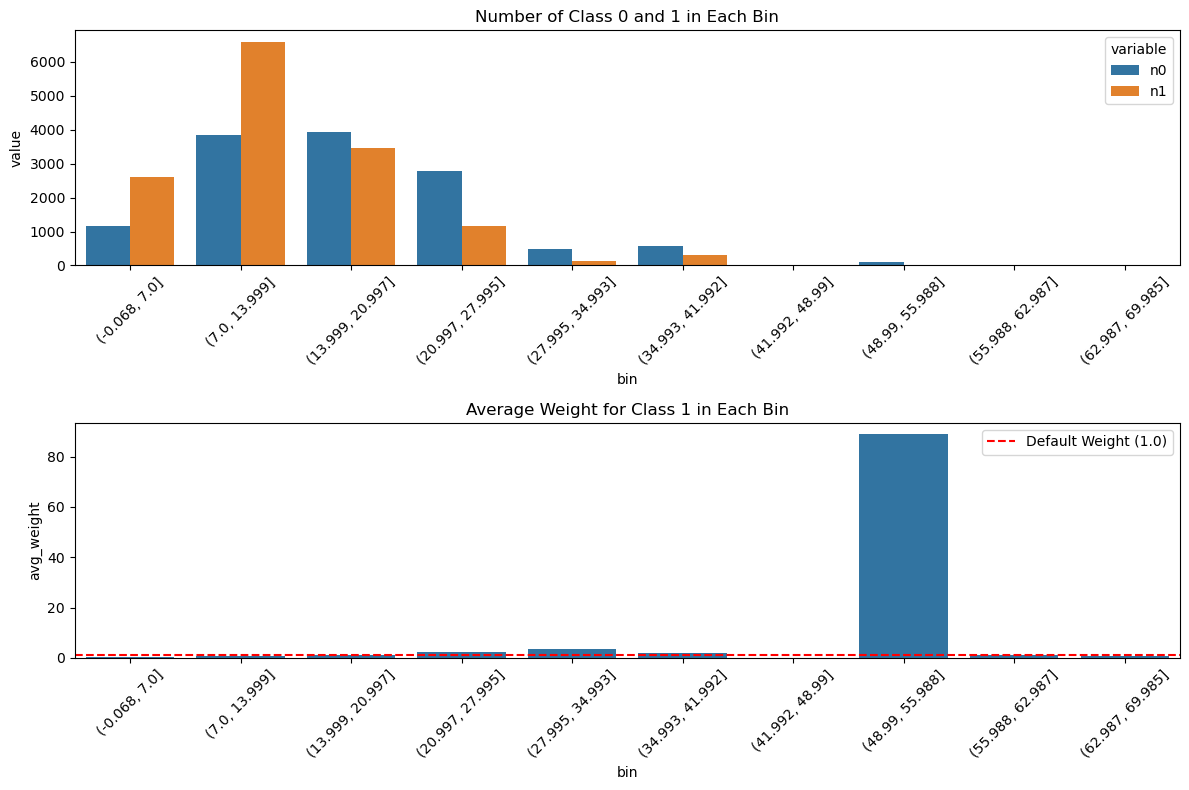

In [ ]:
weights, binned = make_weights(df['result_price_bin'], df['bulvar_ring_km'], bins=10, min_n0=10)
visual(binned, df['result_price_bin'], weights)